In [101]:
import timeit
import pandas as pd
import os
import numpy as np

In [102]:
movies_file = 'data/ml-10M100K/movies.dat'
ratings_file = 'data/ml-10M100K/ratings.dat'

# set static variables
_pickle_dir = os.path.join(os.path.dirname(
    os.path.abspath('eda2.ipynb')), 'data\pickled')

# set appropriate paths for pickle files
_ratings_pickle_filename = 'movie_ratings.pkl'
ratings_pickle_path = os.path.join(_pickle_dir, _ratings_pickle_filename)
_movies_pickle_filename = 'movies.pkl'
movies_pickle_path = os.path.join(_pickle_dir, _movies_pickle_filename)

# try to load from pickle if available
try:
    # load movies df from pickle if it exists
    if os.path.exists(movies_pickle_path+"2"):
        movies_df = pd.read_pickle(movies_pickle_path)
    else :
        movies_df = pd.read_csv(movies_file, engine='python', encoding='utf-8',
                                        sep='::', header=None, names=['movie_id', 'name', 'genres'],
                                        dtype={'movie_id': np.int32, 'name': np.chararray, 'genres': np.chararray})

    # load ratings df from pickle if it exists
    if os.path.exists(ratings_pickle_path+"2"):
        ratings_df = pd.read_pickle(ratings_pickle_path)
    else:
        ratings_df = pd.read_csv(ratings_file, engine='python', encoding='utf-8',
                                        sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'],
                                        dtype={'user_id': np.int32, 'movie_id': np.int32, 'rating': np.int32, 'timestamp': np.float64})
        ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s', utc=True)
# catch exceptions
except Exception as e:
    print(e)


In [103]:
# merge dataframes using inner join
merged_df = pd.merge(ratings_df, movies_df, how="inner", on="movie_id")

# make a set of movie_id where movie has Children genre
# children_movie_ids = set(merged_df.loc[merged_df['genres'].str.contains('Children', na=False), 'movie_id'])
# print(children_movie_ids)

# drop unnecessary columns for performance
# merged_df.drop(['timestamp', 'genres'], axis=1, inplace=True)

# take the average if user has multiple reviews for movie
merged_df = merged_df.groupby(
    by=['movie_id', 'user_id'], as_index=False).agg({"rating": "mean"})

# pivot to make movies as rows and users as columns
merged_df = merged_df.pivot(index='movie_id', columns='user_id', values='rating').fillna(0)

# print(merged_df.shape)


In [69]:
existing_df = pd.read_json('recs-app/public/top_rated_similars_1000.json')
print(existing_df['movie_id'].values[:10])
print(merged_df.loc[296])
print(existing_df.columns)
existing_df['similar_movie_ids'] = [[]] * len(existing_df)


KeyError: 'movie_id'

In [ ]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

sparse_item_df = csr_matrix(merged_df.values)
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(sparse_item_df)

# print(merged_df.iloc[296])

for i in existing_df['movie_id'].values:
    weights, neighbors = model.kneighbors([merged_df.loc[i]], n_neighbors=50)
    neighbors = neighbors[0]  
    print(neighbors[:5])
    similar_movie_ids = list(merged_df.iloc[neighbors[1:4]].index)
    existing_df.at[existing_df[existing_df['movie_id'] == i].index[0], 'similar_movie_ids'] = similar_movie_ids

    for idx, n in enumerate(neighbors[1:4]):
        print(movies_df.loc[movies_df['movie_id'] == i]['name'].values[0],movies_df.loc[movies_df['movie_id'] == merged_df.index[n]]['name'].values[0])


In [ ]:
existing_df.head()
existing_df.to_json('data/top_rated_similars_1000.json', orient='index')

Text(0, 0.5, 'Frequency')

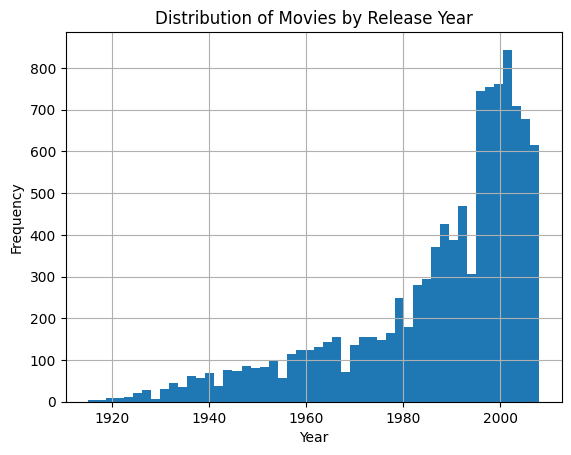

In [110]:
import re
import matplotlib.pyplot as plt

def extract_year(name):
    pattern = r'\((\d{4})\)'
    match = re.search(pattern, name)
    if match:
        return int(match.group(1))
    else:
        return None

movies_df['year'] = movies_df['name'].apply(extract_year)
stats_df = pd.merge(movies_df, ratings_df, how='inner', on='movie_id')

years = movies_df['year'].values

pd.Series(years).hist(bins=50)

# set the plot title and axis labels
plt.title('Distribution of Movies by Release Year')
plt.xlabel('Year')
plt.ylabel('Frequency')

# show the plot
# plt.show()


<AxesSubplot: >

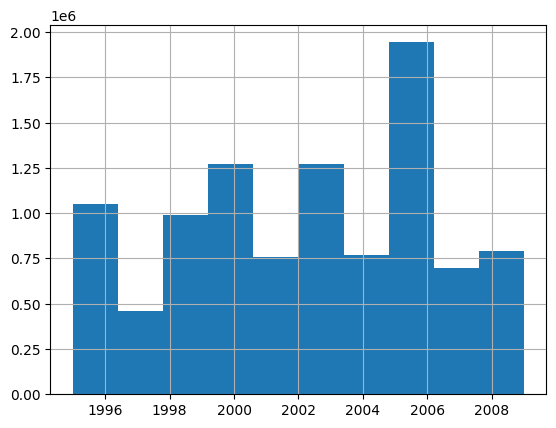

In [108]:
import matplotlib.pyplot as plt

# print(ratings_df['timestamp'].head())
# pd.Series(ratings_df['timestamp']).hist(bins=50)

# Assume the timestamp column has already been converted to UTC datetime format
ratings_df['year'] = ratings_df['timestamp'].dt.year

# Plot a histogram of the year column
ratings_df['year'].hist()
